#### Zoom onto single position of chessboard

In [59]:
# Global imports etc.

import numpy as np
from FEN_to_64grid import FEN_to_seq
from FEN_to_64grid import seq_to_FEN
#For Saving images as files
from PIL import Image
#For file path
import os
from os import listdir
#For plotting
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


In [60]:
#Function to zoom in on a single space
def zoom_to_position(image, position):
    #Assert that image is correct size
    assert image.shape == (400, 400, 3), f"Image shape is {image.shape}, expected (400, 400, 3)"
    assert 1 <= position & position <= 64, f"Position is {position}, expected (1-64)"

    #from position to x/y
    x = (position-1)%8
    y = int((position-1)/8)

    #Make sub array
    sub_image_array = image[y*50:y*50+50, x*50:x*50+50, :]

    return sub_image_array

1

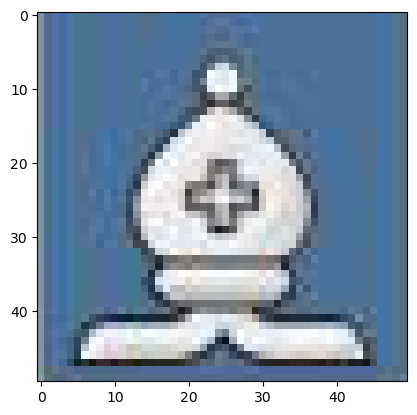

In [61]:
#Test

#Load single chessboard data (file is placed in folder for now)
image_path = 'chessboard_example_images\\1B1B2K1-1B6-5N2-6k1-8-8-8-4nq2.jpeg' #Image must be in root folder
image = mpimg.imread(image_path)

#Test method
zoom_image = zoom_to_position(image,2)
plt.imshow(zoom_image)
len(zoom_image[[[0]]])

#### Split Chessboard into individual position images and store data in folder

In [75]:
#Load data into individual position images
# This method also removes duplicates
def Save_individual_positions(data_path, destination_path):
        for file in os.listdir(data_path):
                #Get FEN from file
                FEN_string = file.replace('.jpeg', '')
                #Convert to seq name
                chessboard_seq = FEN_to_seq(FEN_string)

                #Go thourgh all jpeg images
                if (file.endswith(".jpeg")):
                        # Store file as image data
                        file_path = os.path.join(data_path, file)
                        image = mpimg.imread(file_path)
                        #For all positions
                        for i in range(1,65):
                                #Make file name
                                if (chessboard_seq[i-1] != "_"):
                                        new_file_name = os.path.join(chessboard_seq[i-1]+str(i), chessboard_seq,'.jpeg')
                                else: 
                                        new_file_name = os.path.join(chessboard_seq[i-1]+"_", chessboard_seq,'.jpeg')
                                new_file_name = new_file_name.replace('\\','')
                                #Save image
                                zoom_image = zoom_to_position(image,i)
                                new_image = Image.fromarray(zoom_image.astype('uint8'))
                                new_image.save(os.path.join(destination_path, new_file_name))


In [79]:
# Set data and destination path
data_path = r'C:\Users\Niels\Desktop\MAL\chessboard_example_images_test'
destination_path = r'C:\Users\Niels\Desktop\MAL\position_image_examples_test'

In [80]:
# Save files into folder
Save_individual_positions(data_path, destination_path)

#### Load Individual position images into X and y

In [171]:
#Method to get label from file name

#Load data into individual position images
def Import_individual_positions(data_path):
        X = []
        y = []
        for file in os.listdir(data_path):
                #Go thourgh all jpeg images
                if (file.endswith(".jpeg")):
                        # Store file as image data
                        file_path = os.path.join(data_path, file)
                        image = mpimg.imread(file_path)
                        #store image in X
                        X.append(image)
                        #store label
                        y.append(file[0])
        return X, y

#### Load data

In [173]:
#Folder containing data
data_path = r'C:\Users\Niels\Desktop\MAL\position_image_examples_train' #Set data folder

X_raw, y_raw = Import_individual_positions(data_path)

In [180]:
value = 0
for i in range(0,len(y_raw)):
    if y_raw[i] == 'R':
        value = value+1
print(value)



8705


#### Convert chars to catagorical numbers

In [181]:
from enum import Enum

class CharEnum(Enum):
    _ = 0
    P = 1
    N = 2
    B = 3
    R = 4
    Q = 5
    K = 6
    p = 7
    n = 8
    b = 9
    r = 10
    q = 11
    k = 12

#### CNN setup for data

In [87]:
from keras.utils import to_categorical

In [182]:
#Convert to numpy array
X = np.array(X_raw)
y_num = [CharEnum[char].value for char in y_raw] #Convert ASCII to numbers from 1-13
y = np.array(y_num)

#Preprocess
X = X.reshape(-1, 50, 50, 3).astype('float32') / 255 #RGB pixels from 0-255
y = to_categorical(y, num_classes=None)

In [183]:
#Use sklearns train_test_split to split and shuffle data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

https://numpy.org/doc/stable/reference/generated/numpy.reshape.html

#### Build model

In [92]:
import keras
from keras import layers

In [185]:
#Advanced
def make_advanced_model():
    advanced_model = keras.Sequential()
    advanced_model.add(layers.Conv2D(filters = 6, kernel_size=(2, 2), activation='relu', input_shape=(50,50,3))) #Input layer
    advanced_model.add(layers.MaxPooling2D(pool_size=(2, 2))) #Downsampling layer
    advanced_model.add(layers.Conv2D(filters = 16, kernel_size=(2, 2), activation='relu'))
    advanced_model.add(layers.AveragePooling2D(pool_size=(2, 2)))

    advanced_model.add(layers.Flatten()) #Flatten layer

    #13 pieces (6*2 types + blank space)
    advanced_model.add(layers.Dense(units = 120, activation='relu'))
    advanced_model.add(layers.Dense(units = 84, activation='relu'))
    advanced_model.add(layers.Dense(units = 13, activation='softmax')) #Output layer
    return advanced_model

advanced_model = make_advanced_model()
advanced_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 49, 49, 6)      │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 23, 23, 16)     │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 11, 11, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 120)            │       232,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 13)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,187 (953.86 KB)

 Trainable params: 244,187 (953.86 KB)

 Non-trainable params: 0 (0.00 B)

#### Test/Train split + shuffle

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(validation_split=0.2)
# train_generator = datagen.flow(X_train, y_train, batch_size=32, subset='training')
# validation_generator = datagen.flow(X_train, y_train, batch_size=32, subset='validation')

In [186]:
#Compile
advanced_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Train
history = advanced_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
#Save
advanced_model.save('niels_model.keras')

Epoch 1/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - accuracy: 0.9126 - loss: 0.2909 - val_accuracy: 0.9911 - val_loss: 0.0260
Epoch 2/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.9991 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 1.7671e-04
Epoch 3/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 53s 18ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 1.5805e-04
Epoch 4/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 1.6501e-05
Epoch 5/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 1.1325e-04
Epoch 6/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - accuracy: 1.0000 - loss: 2.3178e-05 - val_accuracy: 1.0000 - val_loss: 8.8043e-06
Epoch 7/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 1.0000 - loss: 7.0918e-07 - val_accuracy: 1.0000 - val_loss: 3.2319e-06
Epoch 8/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 50

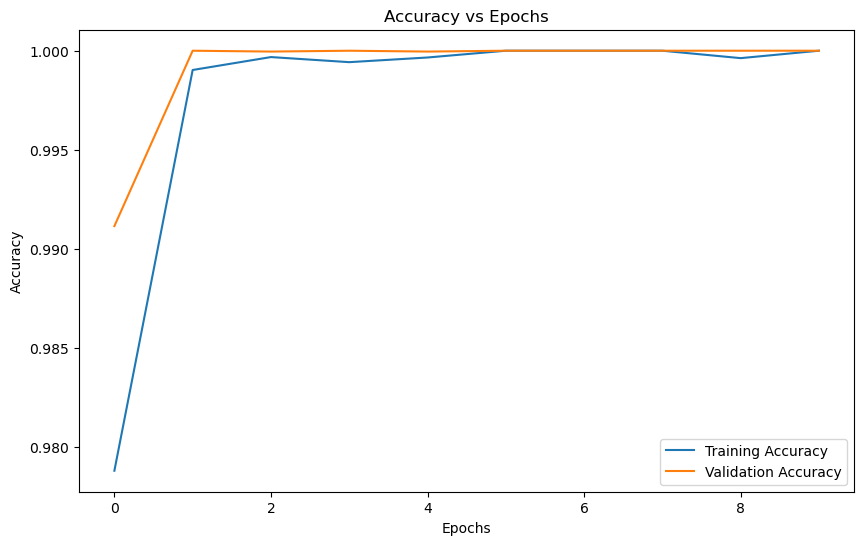

In [187]:
#Plot figure of epoch history

# Save the training history
history_dict = history.history

# Plot Accuracy vs Epochs
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.plot(history_dict['accuracy'], label='Training Accuracy')

# Plot validation accuracy
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')

# Add title and labels
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add legend
plt.legend()

# Show plot
plt.show()

#### Predict

In [202]:
# Set data and destination path
data_path = r'C:\Users\Niels\Desktop\MAL\test_full'
destination_path = r'C:\Users\Niels\Desktop\MAL\test_position'
# Save files into folder
Save_individual_positions(data_path, destination_path)

In [203]:
datapath_test = r'C:\Users\Niels\Desktop\MAL\test_position'
X_test_true, y_test_true = Import_individual_positions(datapath_test)

In [205]:
value = 0
for i in range(0,len(y_test_true)):
    if y_test_true[i] == 'q':
        value = value+1
print(value)

5


In [206]:
#Convert to numpy array
X_test_conv = np.array(X_test_true)
y_num = [CharEnum[char].value for char in y_test_true] #Convert ASCII to numbers from 1-13
y_test_conv = np.array(y_num)

#Preprocess
X_test_conv = X_test_conv.reshape(-1, 50, 50, 3).astype('float32') / 255 #RGB pixels from 0-255
y_test_conv = to_categorical(y_test_conv, num_classes=None)

In [207]:
prediction = advanced_model.predict(X_test_conv)
print(prediction.shape)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
(138, 13)


#### Calculate accuracy and loss from whole test set

In [208]:
loss_from_test, acc_from_test = advanced_model.evaluate(X_test_conv, y_test_conv)
print(f"Loss: {loss_from_test}")
print(f"Accuracy: {acc_from_test}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3501e-06 
Loss: 2.288211589984712e-06
Accuracy: 1.0


#### Confusion matrix

In [209]:
y_pred_classes = np.argmax(prediction, axis=1)
y_true = np.argmax(y_test_conv, axis=1)

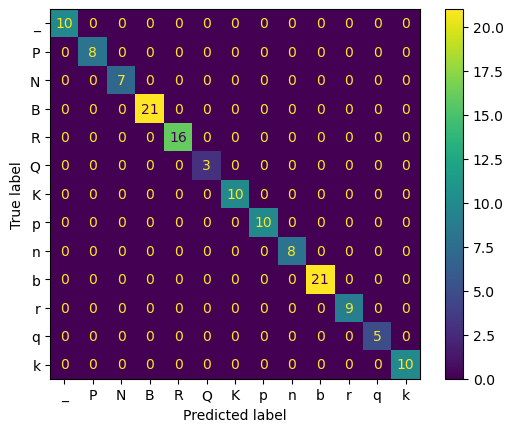

In [210]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_true, y_pred_classes)
class_names = [char.name for char in CharEnum]
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)

cm_display.plot()
plt.show()

#### Predict single image FEN

In [294]:
image_path = r'C:\Users\Niels\Desktop\MAL\test\1QN2q2-3PN3-2N5-8-1B3kP1-R5p1-2K2n1R-1R6.jpeg'


In [291]:
from keras.models import load_model
model = load_model('niels_model.keras')

In [292]:
def Predict_single_image(data_path, model):
        X = []
        seq = ""

        image = mpimg.imread(data_path)

        for i in range(1,65):
                    #Go through all positions and store
                    zoom_image = zoom_to_position(image,i)
                    zoom_image = np.array(zoom_image)
                    zoom_image = zoom_image.reshape(-1, 50, 50, 3).astype('float32') / 255 #RGB pixels from 0-255

                    #Predict label from position
                    prediction = model.predict(zoom_image)
                    y_pred_classes = np.argmax(prediction, axis=1)
                    char = CharEnum(y_pred_classes[0]).name
                    seq += char

        return seq

In [295]:
X = Predict_single_image(image_path,model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

In [297]:
print(X)
seq_to_FEN(X)

_QN__q_____PN_____N______________B___kP_R_____p___K__n_R_R______


'1QN2q2-3PN3-2N5-8-1B3kP1-R5p1-2K2n1R-1R6'